Dimension 1: RMSE = 0.2255, MAE = 0.1734
Dimension 2: RMSE = 0.3624, MAE = 0.1699
Dimension 3: RMSE = 0.3650, MAE = 0.2104
Dimension 4: RMSE = 0.1886, MAE = 0.1419
Dimension 5: RMSE = 0.1968, MAE = 0.1357
Dimension 6: RMSE = 0.2512, MAE = 0.1690
Dimension 7: RMSE = 0.2539, MAE = 0.1537
Dimension 8: RMSE = 0.2485, MAE = 0.1556
Dimension 9: RMSE = 0.2447, MAE = 0.1819
Dimension 10: RMSE = 0.1482, MAE = 0.1176
Overall RMSE: 0.2571
Overall MAE: 0.1609


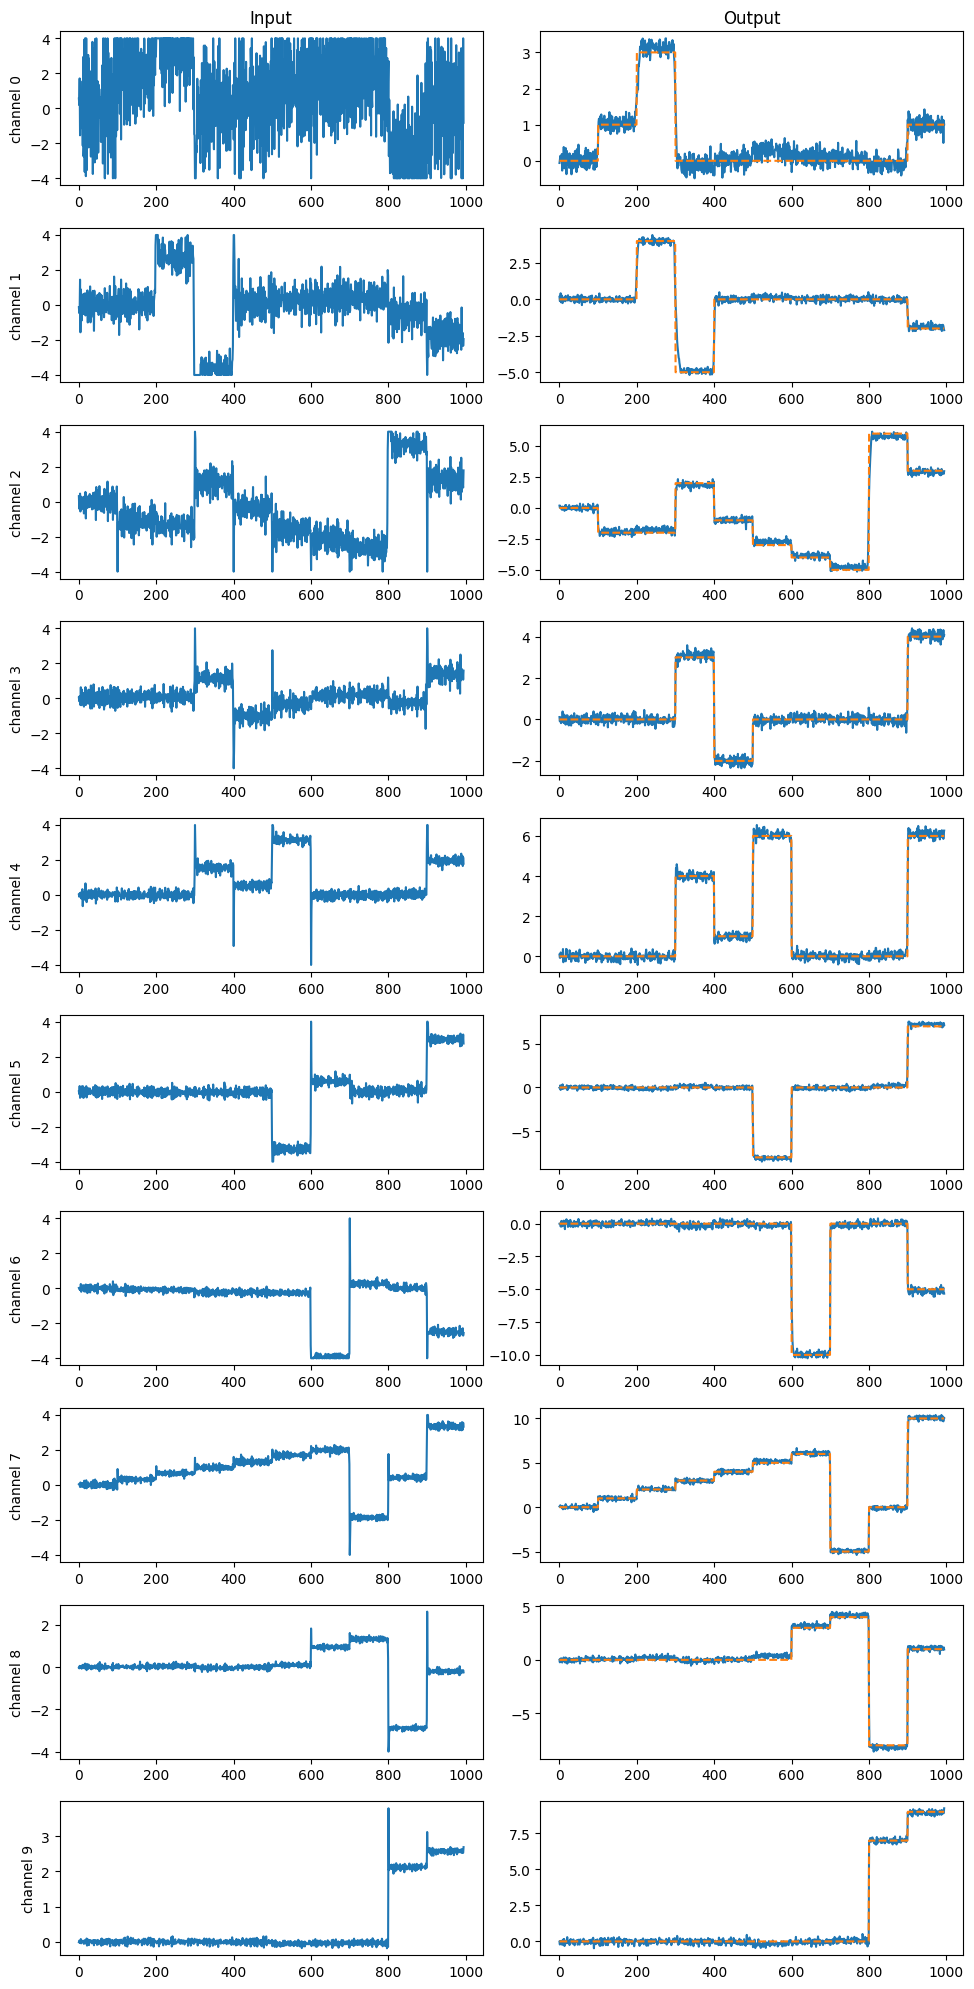

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from deepc import Controller, RandomNoiseDiscreteLTI

# This system models a series of interconnected masses, springs, and dampers.
# Each mass is coupled to its neighbors.
system = RandomNoiseDiscreteLTI(
    A=[[0.9, 0.02, 0.05, 0, 0, 0, 0, 0, 0, 0],
       [0.01, 0.85, 0.02, 0.01, 0, 0, 0, 0, 0, 0],
       [0, 0.03, 0.8, 0.05, 0, 0, 0, 0, 0, 0],
       [0, 0, 0.02, 0.75, 0.04, 0, 0, 0, 0, 0],
       [0, 0, 0, 0.03, 0.7, 0.05, 0, 0, 0, 0],
       [0, 0, 0, 0, 0.02, 0.65, 0.06, 0, 0, 0],
       [0, 0, 0, 0, 0, 0.01, 0.6, 0.07, 0, 0],
       [0, 0, 0, 0, 0, 0, 0.02, 0.55, 0.08, 0],
       [0, 0, 0, 0, 0, 0, 0, 0.01, 0.5, 0.09],
       [0, 0, 0, 0, 0, 0, 0, 0, 0.02, 0.45]],
    B=np.diag([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
    C=np.diag([1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
    D=np.zeros((10, 10)),
    x_ini=[5.0] * 10,
    noise_std=0.1
)

# Define constraints for the input
max_input = +4.0
min_input = -4.0
constraint = lambda u: np.clip(u, min_input, max_input)

# Gather offline data
N = 200
# by defining an input sequence
u_d = np.random.uniform(min_input, max_input, (N, system.input_dim))
# and applying it to the system
y_d = system.apply_multiple(u_d)

# Define how many steps the controller should look back
# to grasp the current state of the system
T_ini = 5

# Define how many steps the controller should look forward
r_len = 5

# Define the controller
controller = Controller(u_d, y_d, T_ini, r_len, input_constrain_fkt=constraint)

# Reset the system
# to sepereate the offline data from the online data
system.set_state([0] * 10)

# Warm up the controller
while not controller.is_initialized():
    u = [0] * 10
    y = system.apply(u)
    controller.update(u, y)

# Simulate the system
u_online = []
y_online = []
r_online = [[0] * 10] * 100 + \
           [[1, 0, -2, 0, 0, 0, 0, 1, 0, 0]] * 100 + \
           [[3, 4, -2, 0, 0, 0, 0, 2, 0, 0]] * 100 + \
           [[0, -5, 2, 3, 4, 0, 0, 3, 0, 0]] * 100 + \
           [[0, 0, -1, -2, 1, 0, 0, 4, 0, 0]] * 100 + \
           [[0, 0, -3, 0, 6, -8, 0, 5, 0, 0]] * 100 + \
           [[0, 0, -4, 0, 0, 0, -10, 6, 3, 0]] * 100 + \
           [[0, 0, -5, 0, 0, 0, 0, -5, 4, 0]] * 100 + \
           [[0, 0, 6, 0, 0, 0, 0, 0, -8, 7]] * 100 + \
           [[1, -2, 3, 4, 6, 7, -5, 10, 1, 9]] * 100
for i in range(len(r_online) - r_len):
    r = r_online[i: i + r_len]
    u = controller.apply(r)[0]
    y = system.apply(u)
    controller.update(u, y)
    u_online.append(u)
    y_online.append(y)

# Plot the results
fig, ax = plt.subplots(10, 2, figsize=(10, 20))
ax[0, 0].set_title("Input")
ax[0, 1].set_title("Output")
for i in range(10):
    ax[i, 0].set_ylabel(f"channel {i}")
    ax[i, 0].plot([u[i] for u in u_online])
    ax[i, 1].plot([y[i] for y in y_online])
    ax[i, 1].plot([r[i] for r in r_online[:len(y_online)]], linestyle="--")
plt.tight_layout()

# Calculate RMSE and MAE
y_online = np.array(y_online)
r_online = np.array(r_online[:len(y_online)])  # Trim the targets to match y_online length
rmse = np.sqrt(np.mean((y_online - r_online) ** 2, axis=0))
mae = np.mean(np.abs(y_online - r_online), axis=0)
for i in range(10):
    print(f"Dimension {i+1}: RMSE = {rmse[i]:.4f}, MAE = {mae[i]:.4f}")
total_rmse = np.sqrt(np.mean((y_online - r_online) ** 2))
total_mae = np.mean(np.abs(y_online - r_online))
print(f"Overall RMSE: {total_rmse:.4f}")
print(f"Overall MAE: {total_mae:.4f}")